In [1]:
# Cell 0 – Imports and constants
import pandas as pd
import numpy as np
import xgboost as xgb
import joblib
import re
import random
from pathlib import Path

PARQUET_PATH = Path("../Datasets/final_tennis_dataset_symmetric.parquet")
PLAYERS_CSV  = Path("../data/atp_players.csv")        # Jeff Sackmann master list
MODEL_PATH   = Path("../models/xgb_model.json")       # replace with .joblib if available
CUTOFF_DATE  = "2024-05-20"                           # last day before RG 2024
DEBUG = True

print("Notebook ready")

Notebook ready


In [3]:
# Cell 1 – Build the feature bank (one latest row per player)
def load_feature_bank(parquet_path: Path, cutoff: str) -> pd.DataFrame:
    """Return a DataFrame indexed by PLAYER1_ID with the most recent row
    before `cutoff` for every player."""
    df = pd.read_parquet(parquet_path)
    df["DATE"] = pd.to_datetime(df["TOURNEY_DATE"].astype(str))
    df = df[df["DATE"] < cutoff]
    idx = df.groupby("PLAYER1_ID")["DATE"].idxmax()
    bank = df.loc[idx].set_index("PLAYER1_ID")
    if DEBUG:
        print(f"[bank] players = {len(bank)}, features = {bank.shape[1]}")
    return bank

bank = load_feature_bank(PARQUET_PATH, CUTOFF_DATE)

bank.head(3)

[bank] players = 1442, features = 195


,TOURNEY_ID,TOURNEY_NAME,DRAW_SIZE,TOURNEY_LEVEL,TOURNEY_DATE,MATCH_NUM,PLAYER1_SEED,PLAYER1_ENTRY,PLAYER1_NAME,PLAYER1_HAND,...,P_BPSAVED_PLAYER1_LAST_2000,P_BPSAVED_PLAYER2_LAST_2000,PLAYER1_ELO_BEFORE,PLAYER2_ELO_BEFORE,ELO_DIFF,PLAYER1_ELO_SURFACE_BEFORE,PLAYER2_ELO_SURFACE_BEFORE,ELO_SURFACE_DIFF,TARGET,DATE
PLAYER1_ID,,,,,,,,,,,,,,,,,,,,,
100644,2024-0416,Rome Masters,128.0,M,20240506,291,3.0,None,Alexander Zverev,R,...,59.859529,55.266512,1892.471746,1545.953131,346.518615,1832.122329,1540.424236,291.698093,1,2024-05-06
101086,2001-421,Canada Masters,64.0,M,20010730,1,NaN,Q,Ronald Agenor,R,...,50.329577,65.298830,1376.068244,1882.788844,-506.720600,1447.530263,1666.142505,-218.612242,0,2001-07-30
101150,2001-375,Lyon,32.0,A,20011008,2,NaN,Q,Gianluca Pozzi,L,...,58.293521,53.846154,1388.915156,1489.765259,-100.850103,1502.291110,1484.257476,18.033635,0,2001-10-08


## Other banks with surfaces 

In [70]:
def build_banks(parquet_path: Path, cutoff: str):
    """
    Returns
      bank_global   : latest row per player (any surface)
      bank_surface  : dict {surface: latest row per player on that surface}
    """
    df = pd.read_parquet(parquet_path)
    df["DATE"] = pd.to_datetime(df["TOURNEY_DATE"].astype(str))
    df = df[df["DATE"] < cutoff]

    # global (any surface)
    idx = df.groupby("PLAYER1_ID")["DATE"].idxmax()
    bank_global = df.loc[idx].set_index("PLAYER1_ID")

    # one bank per surface
    bank_surface = {}
    for surf in SURFACES:
        sub = df[df[f"SURFACE_{surf}"] == 1]
        if sub.empty:
            continue
        idx = sub.groupby("PLAYER1_ID")["DATE"].idxmax()
        bank_surface[surf] = sub.loc[idx].set_index("PLAYER1_ID")

    if DEBUG:
        print(f"[banks] global players = {len(bank_global)}")
        for s in bank_surface:
            print(f"         {s:<5} players = {len(bank_surface[s])}")

    return bank_global, bank_surface


bank_global, bank_surface = build_banks(PARQUET_PATH, CUTOFF_DATE)

[banks] global players = 1442
         CLAY  players = 1059
         GRASS players = 782
         HARD  players = 1222
         CARPET players = 283


In [8]:
# Cell 2 – Convert a player name to his unique ATP ID

def player_name_to_id(first: str, last: str, csv_path: Path = PLAYERS_CSV) -> int:
    """Return the ATP ID of a player from their first and last name."""

    players = pd.read_csv(
        csv_path,
        names=["id", "first", "last", "hand", "dob", "ioc", "height", "wikidata"]
    )

    mask = (
        players["first"].str.lower().str.strip() == first.lower().strip()
    ) & (
        players["last"].str.lower().str.strip() == last.lower().strip()
    )

    matches = players[mask]

    # Errors
    if len(matches) == 0:
        raise ValueError(f"{first} {last} not found in the dataset.")
    if len(matches) > 1:
        print(matches[["id", "first", "last"]])
        raise ValueError(f"{first} {last} is ambiguous in the dataset.")

    pid = int(matches.iloc[0]["id"])

    return pid


alcaraz_id = player_name_to_id("Carlos", "Alcaraz")
sinner_id  = player_name_to_id("Jannik", "Sinner")

print(f"\nAlcaraz ID: {alcaraz_id}")
print(f"Sinner  ID: {sinner_id}")


Alcaraz ID: 207989
Sinner  ID: 206173


/tmp/ipykernel_694856/2721412753.py:6: DtypeWarning: Columns (0,4,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  players = pd.read_csv(
/tmp/ipykernel_694856/2721412753.py:6: DtypeWarning: Columns (0,4,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  players = pd.read_csv(


In [72]:
# Cell 3a – helper : return the stats for ONE player
SURFACES = ["CLAY", "GRASS", "HARD", "CARPET"]

def get_player_stats(player_id: int,
                     prefix: str,
                     surface: str,
                     fallback="GLOBAL") -> pd.Series:
    """
    Return player stats on the requested surface.
    Fallback order:
      1. exact surface row
      2. global latest row (if available and fallback == 'GLOBAL')
      3. raise KeyError
    """
    surf_df = bank_surface.get(surface.upper())
    if surf_df is not None and player_id in surf_df.index:
        row = surf_df.loc[player_id]
    elif fallback == "GLOBAL" and player_id in bank_global.index:
        row = bank_global.loc[player_id]
    else:
        raise KeyError(f"Player {player_id} not found for surface {surface}")

    slice_ = row.filter(regex=r"^PLAYER1_")
    slice_ = slice_.rename(lambda c: c.replace("PLAYER1_", prefix))
    return slice_


Alcaraz = get_player_stats(207989, "PLAYER1_","CLAY")
Alcaraz

PLAYER1_SEED                             2.0
PLAYER1_ENTRY                           None
PLAYER1_NAME                  Carlos Alcaraz
PLAYER1_HAND                               R
PLAYER1_HT                             183.0
PLAYER1_IOC                              ESP
PLAYER1_AGE                             20.9
PLAYER1_ACE                              2.0
PLAYER1_DF                               1.0
PLAYER1_SVPT                            46.0
PLAYER1_1STIN                           31.0
PLAYER1_1STWON                          27.0
PLAYER1_2NDWON                           7.0
PLAYER1_SVGMS                            9.0
PLAYER1_BPSAVED                          1.0
PLAYER1_BPFACED                          2.0
PLAYER1_RANK                             3.0
PLAYER1_RANK_POINTS                   8145.0
PLAYER1_TOTAL_MATCHES                    211
PLAYER1_SURFACE_MATCHES                   78
PLAYER1_LAST_3_WINRATE              0.666667
PLAYER1_LAST_5_WINRATE                   0.8
PLAYER1_LA

In [74]:
# Cell 3b – build the full feature row for the match
def build_match_row(p1: int, p2: int, surface: str = "CLAY") -> pd.DataFrame:
    r1 = get_player_stats(p1, "PLAYER1_", surface)
    r2 = get_player_stats(p2, "PLAYER2_", surface)
    feat = pd.concat([r1, r2])

    # engineered gaps
    feat["ATP_POINT_DIFF"] = feat["PLAYER1_RANK_POINTS"] - feat["PLAYER2_RANK_POINTS"]
    feat["ATP_RANK_DIFF"]  = feat["PLAYER2_RANK"] - feat["PLAYER1_RANK"]
    feat["AGE_DIFF"]       = feat["PLAYER1_AGE"] - feat["PLAYER2_AGE"]
    feat["HEIGHT_DIFF"]    = feat["PLAYER1_HT"]  - feat["PLAYER2_HT"]
    feat["RANK_RATIO"]     = feat["PLAYER1_RANK"] / feat["PLAYER2_RANK"]
    feat["ELO_SURFACE_DIFF"] = (
        feat["PLAYER1_ELO_SURFACE_BEFORE"] - feat["PLAYER2_ELO_SURFACE_BEFORE"]
    )

    # one‑hot surface
    for s in SURFACES:
        feat[f"SURFACE_{s}"] = int(surface.upper() == s)

    # keep numerics only
    #feat = feat.apply(pd.to_numeric, errors="coerce")
    return feat.to_frame().T



rowMatch = build_match_row(alcaraz_id, sinner_id, 'CLAY')
rowMatch


,PLAYER1_SEED,PLAYER1_ENTRY,PLAYER1_NAME,PLAYER1_HAND,PLAYER1_HT,PLAYER1_IOC,PLAYER1_AGE,PLAYER1_ACE,PLAYER1_DF,PLAYER1_SVPT,...,ATP_POINT_DIFF,ATP_RANK_DIFF,AGE_DIFF,HEIGHT_DIFF,RANK_RATIO,ELO_SURFACE_DIFF,SURFACE_CLAY,SURFACE_GRASS,SURFACE_HARD,SURFACE_CARPET
0,2.0,None,Carlos Alcaraz,R,183.0,ESP,20.9,2.0,1.0,46.0,...,-515.0,-1.0,-1.7,-8.0,1.5,102.040325,1,0,0,0


In [75]:
# Cell 4 – Charger le modèle
def load_model(path: Path):
    model = xgb.XGBClassifier()
    model.load_model(path)
    
    if DEBUG: print(f"[model] booster rounds={model.get_booster().num_boosted_rounds()}")
    
    return model

model = load_model(MODEL_PATH)

[model] booster rounds=100


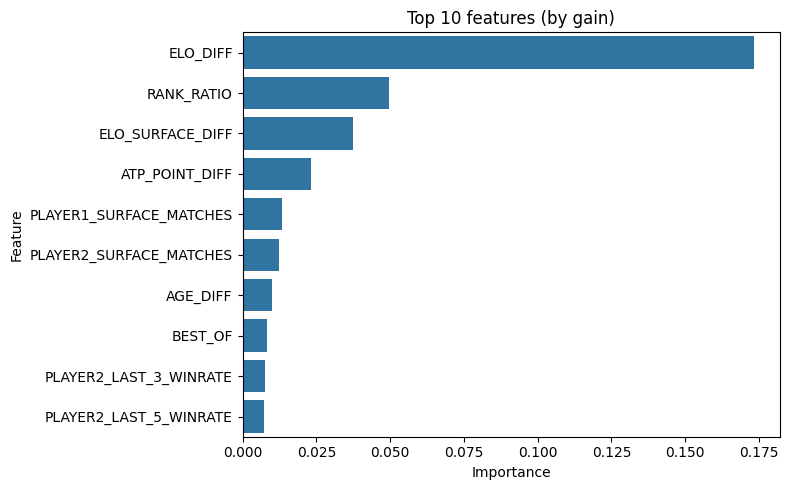

In [88]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
sns.barplot(data=feat_imp.head(10), x="Importance", y="Feature")
plt.title("Top 10 features (by gain)")
plt.tight_layout()
plt.show()


In [76]:
rowMatch = build_match_row(alcaraz_id, sinner_id, 'CLAY')

rowMatch['AGE_DIFF']
rowMatch.head()
print(rowMatch['PLAYER2_NAME'])
print(rowMatch['ELO_SURFACE_DIFF'])
print(rowMatch['PLAYER1_ELO_SURFACE_BEFORE'])
print(rowMatch['PLAYER2_ELO_SURFACE_BEFORE'])
print(rowMatch['PLAYER1_ELO_BEFORE'])
print(rowMatch['PLAYER2_ELO_BEFORE'])


print("----------------")

rowMatchHARD = build_match_row(alcaraz_id, sinner_id, 'HARD')

rowMatch['AGE_DIFF']
rowMatch.head()
print(rowMatchHARD['PLAYER2_NAME'])
print(rowMatchHARD['ELO_SURFACE_DIFF'])
print(rowMatchHARD['PLAYER1_ELO_SURFACE_BEFORE'])
print(rowMatchHARD['PLAYER2_ELO_SURFACE_BEFORE'])
print(rowMatchHARD['PLAYER1_ELO_BEFORE'])
print(rowMatchHARD['PLAYER2_ELO_BEFORE'])


0    Jannik Sinner
Name: PLAYER2_NAME, dtype: object
0    102.040325
Name: ELO_SURFACE_DIFF, dtype: object
0    1899.709648
Name: PLAYER1_ELO_SURFACE_BEFORE, dtype: object
0    1797.669322
Name: PLAYER2_ELO_SURFACE_BEFORE, dtype: object
0    2032.892965
Name: PLAYER1_ELO_BEFORE, dtype: object
0    2139.612443
Name: PLAYER2_ELO_BEFORE, dtype: object
----------------
0    Jannik Sinner
Name: PLAYER2_NAME, dtype: object
0   -109.195245
Name: ELO_SURFACE_DIFF, dtype: object
0    2005.560526
Name: PLAYER1_ELO_SURFACE_BEFORE, dtype: object
0    2114.755772
Name: PLAYER2_ELO_SURFACE_BEFORE, dtype: object
0    2043.498536
Name: PLAYER1_ELO_BEFORE, dtype: object
0    2130.961868
Name: PLAYER2_ELO_BEFORE, dtype: object


In [78]:
# Cell 5 – predict using the new builders
def predict_match(p1: int, p2: int, surface: str) -> float:
    """
    Return probability that Player 1 beats Player 2.
    """
    X = build_match_row(p1, p2, surface)

    # Align to the exact training schema
    model_features = model.get_booster().feature_names
    X = X.reindex(columns=model_features, fill_value=0.0).astype(np.float32)

    p1_win = float(model.predict_proba(X)[0, 1])

    return p1_win


# sanity test
p_alcaraz = predict_match(alcaraz_id, sinner_id, "HARD")
print(f"\nAlcaraz win prob: {p_alcaraz:.1%}")
print(f"Sinner  win prob: {(1 - p_alcaraz):.1%}")


Alcaraz win prob: 49.9%
Sinner  win prob: 50.1%


In [ ]:
# Cell 6 – Simple Monte Carlo simulation (optional)
def simulate(p1: int, p2: int, n: int = 1000, surface: str = "HARD", seed: int = 0) -> float:
    """Return the proportion of wins for Player1 over `n` simulated matches."""
    rng = random.Random(seed)
    wins = 0
    for _ in range(n):
        p = predict_match(p1, p2, surface)
        wins += rng.random() < p
    return wins / n

mc_alcaraz = simulate(alcaraz_id, sinner_id, n=1000)
print(f"\nMonte‑Carlo (5000 draws) – Alcaraz wins {mc_alcaraz:.1%}")
print(f"\nMonte‑Carlo (5000 draws) – Sinner wins {1 - mc_alcaraz:.1%}")